In [13]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
USER='wilderlavington'
PROJECT='FunctionalStochasticOptimization'
SUMMARY_FILE='sharan_report_0831.csv'
import time
import matplotlib as mpl

((0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6))

In [7]:

K=1
def smooth(array, k):
    array = np.array(array)
    new_array = deepcopy(array)
    # print(array[max(0,i-k):i] )
    for i in range(len(array)):
        if str(array[i]) != 'nan':
            avg_list = [val for val in array[max(0,i-k):i+1] if str(val) != 'nan']
            new_array[i] = sum(avg_list) / len(avg_list)
    return new_array


In [8]:
def format_dataframe(records, id_subfields={}, avg_subfields=['seed'],
            max_subfields=['log_eta', 'eta_schedule', 'c'],
            x_col='optim_steps', y_col='avg_loss'):
    #
    pd.set_option('display.max_columns', None)
    max_subfields = [m for m in max_subfields if m not in id_subfields.keys()]

    for key in id_subfields:
        print(key, records[key].unique())
        records = records.loc[records[key] == id_subfields[key]]
    records['function_evals+grad_evals'] = records['function_evals']+records['grad_evals']
    if not len(records):
        raise Exception
    # remove nans
    records = records[records[y_col].notna()]
    important_cols = list(set(avg_subfields+max_subfields+\
        list(id_subfields.keys())+[x_col, y_col, 'optim_steps']))
    # remove redundant information
    records = records[important_cols]
    # average over avg_subfields
    records = records.drop(avg_subfields, axis=1)
    # group over averaging field
    gb = list(set(list(max_subfields+list(id_subfields.keys())+[x_col, 'optim_steps'])))
    # only look at final optim steps
    last_mean_records = records.loc[records['optim_steps'] == records['optim_steps'].max()]
    # get the best record
    best_record = last_mean_records[last_mean_records[y_col] == last_mean_records[y_col].min()]
    # find parameters of the best record
    merge_on = list(set(gb)-set(['optim_steps', x_col, y_col]))
    merge_on = [ x for x in merge_on if x in best_record.columns.values]
    best_records = pd.merge(best_record[merge_on], records, on=merge_on,how='left')
    final_records = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].mean()
    final_records[y_col+'25'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.25)[y_col]
    final_records[y_col+'75'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.75)[y_col]
    final_records = final_records.sort_values(x_col, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    # smooth outputs 
    final_records[y_col+'75'] = smooth(final_records[y_col+'75'],K)
    final_records[y_col+'25'] = smooth(final_records[y_col+'25'],K)
    final_records[y_col] = smooth(final_records[y_col],K)
    return final_records

In [ ]:
def generate_plot(proc_df, x, y, ax, label, linestyle='solid', color=None):
    low_order_idx = (torch.tensor(proc_df[x].values) < x_max).nonzero().reshape(-1)
    if label:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label=label, linestyle=linestyle, color=color,
                linewidth=4)
    else:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label='_nolegend_', linestyle=linestyle, color=color,
                linewidth=4)
    ax.fill_between(torch.tensor(proc_df[x].values)[low_order_idx],
            torch.tensor(proc_df[y+'75'].values)[low_order_idx],
            torch.tensor(proc_df[y+'25'].values)[low_order_idx],
            alpha = 0.5, label='_nolegend_', linestyle=linestyle, color=color)
    return ax

def generate_A1_figure(loss, dataset_name):
    
    # base info   
    schedules = ['constant', 'stochastic', 'exponential']
    batch_sizes = [25, 125, 625]
    m = [1, 2, 5, 10, 20]
    x = 'time_elapsed'
    y = 'grad_norm'
    
    # init plots 
    fig, axs = plt.subplots(SCHEDULES, BATCHES)
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD':colors[0], 'SLS':colors[1]}.\
        update({'FuncOpt'+str(m_):colors[idx+2] for idx, m_ in enumerate(m)})
    fig.title('Comparison of SGD/SLS/FuncOpt: '+loss+'-'+dataset_name)
    
    # now add in the lines to each of the plots 
    for row, schedule in enumerate(schedules):
        for col, batch_size in enumerate(batch_sizes):
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, 'episodes': episodes,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': eta_schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                                             linestyle='dotted', color=colormap['SLS'])
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, 'episodes': episodes,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': eta_schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                                             linestyle='dotted', color=colormap['SGD'])
            
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(records, 
                    id_subfields={'batch_size': batch_size, 'episodes': episodes,
                        'use_optimal_stepsize': 1,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': eta_schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col='grad_norm', y_col='time_elapsed')
                # generate the associated plot 
                ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], \
                                            label, color=colormap['FuncOpt'+str(m_)])
            
            # FMDopt grid_searched  
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(records, 
                    id_subfields={'batch_size': batch_size, 'episodes': episodes,
                        'use_optimal_stepsize': 0,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': eta_schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['log_eta', 'c'],
                    x_col='grad_norm', y_col='time_elapsed') 
                ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                           linestyle='dotted', color=colormap['FuncOpt'+str(m_)])
                ax[row][col].grid()
    
    # remaining format stuff 
    fig.tight_layout()
    plt.legend()
    plt.yscale("log")
    plt.rcParams['figure.dpi'] = 400
    plt.xlabel(x)
    plt.ylabel(y)
    
    # show / save
    plt.savefig(loss+'_'+dataset_name+'.pdf', bbox_inches='tight')
    plt.show() 
   

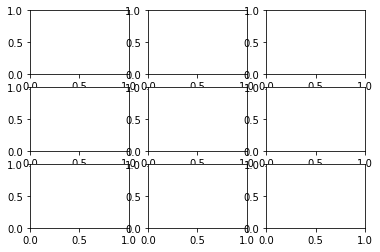

In [12]:
def generate_A1_figure(loss, dataset_name):
    
    # base info   
    schedules = ['constant']
    batch_sizes = [25, 125, 625]
    m = [1, 2, 5, 10, 20]
    x = 'time_elapsed'
    y = 'grad_norm'
    
    # init plots 
    fig, axs = plt.subplots(SCHEDULES, BATCHES)
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD':colors[0], 'SLS':colors[1]}.\
        update({'FuncOpt'+str(m_):colors[idx+2] for idx, m_ in enumerate(m)})
    fig.title('Comparison of Adagrad/Ada-FuncOpt: '+loss+'-'+dataset_name)
    
    # now add in the lines to each of the plots 
    for row, schedule in enumerate(schedules):
        for col, batch_size in enumerate(batch_sizes):
            # Adagrad
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, 'episodes': episodes,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
                'eta_schedule': eta_schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                                             linestyle='dotted', color=colormap['SLS'])
             
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(records, 
                    id_subfields={'batch_size': batch_size, 'episodes': episodes,
                        'use_optimal_stepsize': 0, 'log_eta': -3, 
                        'loss': loss, 'algo': 'Ada_FMDOpt', 'm': m_,
                        'eta_schedule': eta_schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col='grad_norm', y_col='time_elapsed')
                # generate the associated plot 
                ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], \
                                            label, color=colormap['FuncOpt'+str(m_)])
            
            # FMDopt grid_searched  
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(records, 
                    id_subfields={'batch_size': batch_size, 'episodes': episodes,
                        'use_optimal_stepsize': 0,
                        'loss': loss, 'algo': 'Ada_FMDOpt', 'm': m_,
                        'eta_schedule': eta_schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['log_eta', 'c'],
                    x_col='grad_norm', y_col='time_elapsed') 
                ax[row][col] = generate_plot(proc_df, x, y, ax[row][col], label=None, 
                           linestyle='dotted', color=colormap['FuncOpt'+str(m_)])
                ax[row][col].grid()
    
    # remaining format stuff 
    fig.tight_layout()
    plt.legend()
    plt.yscale("log")
    plt.rcParams['figure.dpi'] = 400
    plt.xlabel(x)
    plt.ylabel(y)
    
    # show / save
    plt.savefig(loss+'_'+dataset_name+'.pdf', bbox_inches='tight')
    plt.show() 